## Введение

В данной работе представлены три нейронные сети М1, М2 и М3 по классификации изображений. Сеть М1 работатет непосредственно с дирректориями в которых расположены изображения. Для сетей М2 и М3 выполняется предварительная подготовка изображений и загрузка их в виде массивов данных

## 1 Импорт необходимы библиотек

In [ ]:
import time
import os
import shutil
import keras
import numpy as np
import json
import matplotlib.pyplot as plt
from google.colab import files, drive
from io import BytesIO
from PIL import Image
from keras.layers import Conv2D, UpSampling2D, InputLayer, Activation, Flatten, MaxPooling2D, AveragePooling2D, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory, plot_model as pltm
import tensorflow as tf

## 2 Подключение к google disk

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## 3 Опреденление необходимых путей к директориям на G диске

In [ ]:
path = "/content/drive/MyDrive/"
path_pets = path + "Cats_vs_Dogs/PetImages/"

In [ ]:
# Каталог для обучения
train_dir = 'train'
# Католог для проверки
val_dir = 'val'
# Каталог для тестирования
test_dir = 'test'
# Часть данных для тестирования
test_data_part = 0.15
# Часть данных для проверки
val_data_part = 0.15
# Общее количество данных в одном классе
num_data_in_class = len(os.listdir(path_pets + "Cat")[:500])

## 4 Определение необходимых функций

In [ ]:
def Zeros(x):
    """# Функция возвращающая нулевой массив. (Необходима для перемешивания данных в словаре)"""
    # x - массив ввиде np.array(x)
    if type(x) != np.ndarray:
        x = np.asarray(x)
    return np.zeros(x.shape)


def Shuffle_dict(x_dict):
    """# Функция перемешивания данных в словаре"""
    # x_dict - словарь
    new_val = []
    end_count = len(x_dict[list(x_dict.keys())[1]])
    shuffle_list = np.arange(0, end_count)
    np.random.shuffle(shuffle_list)
    for key, val in x_dict.items():
        zer = Zeros(x_dict[key])
        for indx in range(len(val)):
            zer[shuffle_list[indx]] = val[indx]
        x_dict[key] = zer
    return x_dict


def Reshape_2D_to_3D(x1, x2):
    """# Фукция преобразования двумерного массива в трех мерный в случае необходимости"""
    """Функция преобразует 2D массив в 3D в случае необходимости"""
    if len(x1.shape[1:]) > 2:
        return x1, x2
    else:
        x1 = np.expand_dims(x1, axis=3)
        x2 = np.expand_dims(x2, axis=3)
        return x1, x2


def Input_layer(x):
    """# Функция определяющая входной слой"""
    """Функция формирует входной слой для модели в зависимости от размерности массива"""
    if len(x.shape[1:]) > 2:
        a = x.shape[-1]
    else:
        a = 1
    return Input(shape=(x.shape[1],x.shape[2],a), name='inputs')


def compile_models(Model, X_train, X_test, Y_train, Y_test, model_batch=250, model_epoch=5, model_metrics='accuracy', model_patience=10):
    """# Функция позволяющая определять наилучшую модель из нескольких созданных моделей с разными параметрами"""
    """Функция осуществляет подбор наилудчшей модели с несколькими оптимизаторами"""
    print("Start")
    start = time.time()
    result_dict = {}
    X_train, X_test = Reshape_2D_to_3D(X_train, X_test)
    callback_1 = EarlyStopping(monitor=model_metrics, patience=model_patience)
    for n1, model_i in enumerate(Model['models']): # Для каждой модели
        n1 += 1
        for n2, model_optimazer in enumerate(Model['optimizers']): # Для каждого оптимизатора
            n2 += 1
            for n3, loss_i in enumerate(Model['losses']): # Для каждой функции потерь
                n3 += 1
                # Компиляция модели
                print(f'Компиляция модели: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                model_i.compile(optimizer=model_optimazer, loss=loss_i, metrics=[model_metrics])
                # Обучение модели
                print(f'Обучение модели: Model {n1}  Optimizer {n2} Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                model_i.fit(X_train, Y_train, batch_size=model_batch, epochs=model_epoch, validation_data=(X_test, Y_test), callbacks=[callback_1])
                # Оценка модели
                print(f'Оценка модели: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                test_loss, test_acc = model_i.evaluate(X_test,  Y_test, verbose=0)
                # Запись результатов оценки модели в словарь
                # Лучшая модель будет определяться по наибольшемы результату метрики accuracy
                print(f'Запись результатов: Model {n1}  Optimizer {n2}  Loss {n3}  Batch={model_batch}  Epochs={model_epoch}  Metrics={model_metrics}')
                print("*"*90)
                result_dict[f'Model_{n1}__Optimizer_{n2}__Loss_{n3}'] = test_acc

    model_keys_list = list(result_dict.keys())
    model_values_list = list(result_dict.values())

    best_accuracy = max(model_values_list)
    count_best_accuracy = model_values_list.count(best_accuracy)

    best_model_dict = {}

    print('Определение наилудчшей модели')
    for acc in range(count_best_accuracy):
        model_keys_list = list(result_dict.keys())
        model_values_list = list(result_dict.values())
        if best_accuracy in model_values_list:
            acc_index = model_values_list.index(best_accuracy)
            best_model_dict[model_keys_list[acc_index]] = best_accuracy
            result_dict.pop(model_keys_list[acc_index])
        else:
            break
    stop = time.time()
    print("Time", stop - start)
    return best_model_dict

def create_directory(dir_name, name1, name2):
    """# Создание каталога с двумя подкаталогами"""
    """# Проверка наличия каталога по указанному пути dir_name"""
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name, name1))
    os.makedirs(os.path.join(dir_name, name2))

#
def copy_images_cat(start_idx, end_idx, source_dir, dest_dir, name1):
    """Функция копирование из каталога Cat"""
    for i in range(start_idx, end_idx):
        shutil.copy2(os.path.join(source_dir, "cat." + str(i) + ".jpg"), os.path.join(dest_dir, name1))

#
def copy_images_dog(start_idx, end_idx, source_dir, dest_dir, name1):
    """Функция копирование из каталога Dog"""
    for i in range(start_idx, end_idx):
        shutil.copy2(os.path.join(source_dir, "dog." + str(i) + ".jpg"), os.path.join(dest_dir, name1))

#
def plot_image(i, predictions_array, true_labels, img, class_name):
    """Функция визуализации изображения"""
    true_label, img = true_labels[i], image.array_to_img(img[i])
    true_label = int(true_label)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}%".format(class_names[true_label],
                                100*np.max(predictions_array)),
                                color=color)


## 5 Создание каталогов train, test, val

In [ ]:
create_directory(path + train_dir, "train_cats", "train_dogs")
create_directory(path + val_dir, "val_cats", "val_dogs")
create_directory(path + test_dir, "test_cats", "test_dogs")

In [ ]:
os.listdir(path)[-9:]

['APosmitnyj_solution.ipynb',
 'HW4_Regression_trees.ipynb',
 'My_folder',
 'archive.zip',
 'Cats_vs_Dogs',
 'Untitled_new',
 'train',
 'val',
 'test']

## 6 Произведем разметку изображений путем переименования файлов добавив к основному имени cat. и dog.

In [ ]:
count = 0
dir_count = 0
for dir_img in os.listdir(path_pets):
    dir_count += 1
    print(dir_img, dir_count)
    for img in os.listdir(path_pets + dir_img):
        if dir_count == 1:
            shutil.move(path_pets + dir_img + "/" + img, path_pets + dir_img + "/" + "cat." + img)
        else:
            shutil.move(path_pets + dir_img + "/" + img, path_pets + dir_img + "/" + "dog." + img)
        count += 1
        if count % 1000 == 0:
            print(f'Размечено {count} изображений')

## 7 Копирование изображения из скаченного архива в каталоки train, test и val

In [ ]:
# Копирование будем производить через индексы изображений
# Определим копируемые диаппазоны
start_val_data_idx = int((num_data_in_class * (1 - val_data_part - test_data_part)) // 1)
start_test_data_idx = int((num_data_in_class * (1 - test_data_part)) // 1)
start_val_data_idx, start_test_data_idx

(350, 425)

In [ ]:
copy_images_cat(0, start_val_data_idx, path_pets + "Cat", path + train_dir, "train_cats")
copy_images_dog(0, start_val_data_idx, path_pets + "Dog", path + train_dir, "train_dogs")
copy_images_cat(start_val_data_idx, start_test_data_idx, path_pets + "Cat", path + val_dir, "val_cats")
copy_images_dog(start_val_data_idx, start_test_data_idx, path_pets + "Dog", path + val_dir, "val_dogs")
copy_images_cat(start_test_data_idx, num_data_in_class, path_pets + "Cat", path + test_dir, "test_cats")
copy_images_dog(start_test_data_idx, num_data_in_class, path_pets + "Dog", path + test_dir, "test_dogs")

## 8 Определение вспомагательных переменных

In [ ]:
# Размер изображения
img_width, img_height = 150, 150
# Размер входного тензора
input_shape = (img_width, img_height, 3)

In [ ]:
# Количество эпох
epochs = 30
# Размер мини-выборки
batch_size = 50

In [ ]:
# Количество изображений
train_labels_cat = len(os.listdir(path + train_dir + "/train_cats"))
train_labels_dog = len(os.listdir(path + train_dir + "/train_dogs"))
val_labels_cat = len(os.listdir(path + val_dir + "/val_cats"))
val_labels_dog = len(os.listdir(path + val_dir + "/val_dogs"))
test_labels_cat = len(os.listdir(path + test_dir + "/test_cats"))
test_labels_dog = len(os.listdir(path + test_dir + "/test_dogs"))
# Количество изображений для обучения
num_train_labels = train_labels_cat + train_labels_dog
# Количество изображений для проверки
num_validation_labels = val_labels_cat + val_labels_dog
# Количество изображений для тестирования
num_test_labels = test_labels_cat + test_labels_dog

In [ ]:
num_train_labels, num_validation_labels, num_test_labels

(700, 150, 150)

## 9 Создание генераторов

In [ ]:
data_generate = ImageDataGenerator(rescale=1. / 255)

### 9.1 Тренировочного

In [ ]:
train_generator = data_generate.flow_from_directory(path + train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

Found 700 images belonging to 2 classes.


### 9.2 Валидационный

In [ ]:
validation_generator = data_generate.flow_from_directory(path + val_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

Found 150 images belonging to 2 classes.


### 9.3 Тестовый

In [ ]:
test_generator = data_generate.flow_from_directory(path + test_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

Found 150 images belonging to 2 classes.


## 10 Создание сверточной нейронной сети СНС M1



### 10.1 Определение ранего останова обучения

In [ ]:
# @title Если на протежении 10 эпох метрика accuracy (точность) не изменятся, обучение модели будет остановленно
callback = EarlyStopping(monitor='accuracy', patience=10)

### 10.2 Создание слоев СНС М1

In [ ]:
model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=input_shape, activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

### 10.3 Просмотр структуры СНС М1

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)       

### 10.4 Визуализация схемы M1

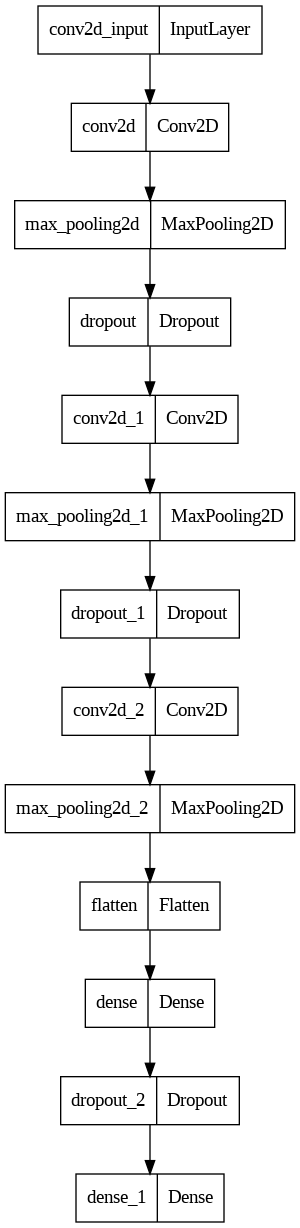

In [ ]:
pltm(model)

### 10.5 Компиляция М1

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 10.6 Обучение М1

In [ ]:
start = time.time()
model.fit_generator(train_generator,
                    steps_per_epoch=num_train_labels // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_train_labels // batch_size, verbose=1)
stop = time.time()
print("Time", stop - start)

<ipython-input-74-697f94e95596>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.7734 - accuracy: 0.4829

14/14 [==============================] - 128s 9s/step - loss: 0.7734 - accuracy: 0.4829 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
14/14 [==============================] - 2s 151ms/step - loss: 0.6936 - accuracy: 0.4957
Epoch 3/30
14/14 [==============================] - 2s 148ms/step - loss: 0.6924 - accuracy: 0.5300
Epoch 4/30
14/14 [==============================] - 2s 152ms/step - loss: 0.6891 - accuracy: 0.5257
Epoch 5/30
14/14 [==============================] - 2s 160ms/step - loss: 0.6904 - accuracy: 0.5071
Epoch 6/30
14/14 [==============================] - 3s 203ms/step - loss: 0.6829 - accuracy: 0.5600
Epoch 7/30
14/14 [==============================] - 2s 154ms/step - loss: 0.6918 - accuracy: 0.5543
Epoch 8/30
14/14 [==============================] - 2s 150ms/step - loss: 0.6922 - accuracy: 0.4886
Epoch 9/30
14/14 [==============================] - 2s 159ms/step - loss: 0.6922 - accuracy: 0.5143
Epoch 10/30
14/14 [==============================] - 3s 180ms/step - l

### 10.7 Оценка М1

In [ ]:
scores = model.evaluate_generator(test_generator, num_test_labels // batch_size)

<ipython-input-75-d9f20e4d0a02>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, num_test_labels // batch_size)


In [ ]:
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 66.67%


### 10.8 Сохранение и загрузка М1

In [ ]:
model.save('drive/MyDrive/My_model/')
my_model = keras.models.load_model('drive/MyDrive/My_model')

### 10.9 Выполнение предсказаний М1 на тестовой выборке

In [ ]:
pred = my_model.predict(test_generator)

3/3 [==============================] - 1s 146ms/step


## 11 Визуализация одного из распознонаных изображений с процентом точности

Text(0.5, 0, 'dog 19.68 %')

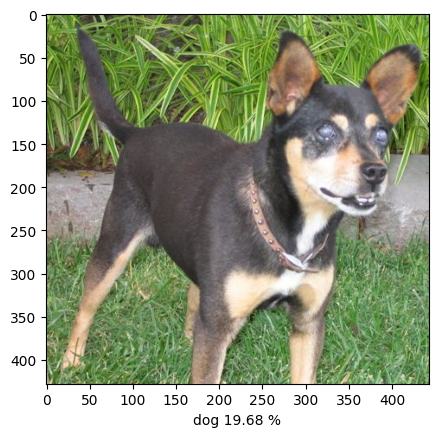

In [ ]:
i = 100
xlbl = pred[i][0]
img_path = test_generator.filepaths[i]
img_for_plot = image.load_img(img_path)
plt.imshow(img_for_plot)
plt.xlabel(f"{img_path[-11:-8]} {round(xlbl * 100, 3)} %")

In [ ]:
# @title Средняя точность предсказаний на тестовой выборке
print(f"Средняя точность предсказаний на тестовой выборке {round(np.mean(pred) * 100, 2)} %")

Средняя точность предсказаний на тестовой выборке 50.43 %


### По результатам тестирование М1, обучение которой проводилось на выборке объемом 700 изображений, выступающих как тренировочные. Процент точности предсказания на тестовой выборке составил 50.43 %

## 12 Подготовка данных для реализация СНС М2 и М3

## 13 Выполним процедуру подготовки данных с использованием модулю Image

### 13.1 Путь к директории где будут храниться сжатые изображения с необходимыми размерами 100х100

In [ ]:
cat_dog = path + "Cat_and_Dog"

### 13.2 Создание необходимой директории

In [ ]:

if os.path.exists(cat_dog):
    shutil.rmtree(cat_dog)
os.makedirs(cat_dog)

## 14 Скачивание изображений из исходных каталогов, паралельное сжатие и сохранение их в рабочую деректорию

In [ ]:
# С какого изображения начать скачивание
start_ind_img = 0
# До какого изображения
end_ind_img = 1001
# Размеры изображения ШхВ (Ширина, Высота)
width, heigh = 100, 100
for c in range(start_ind_img, end_ind_img):
    # Изображение с индексом 666 небыло определено при первом проходе. Соответственно на данный индекс установлена заглушка
    if c == 666:
        pass
    # Открытие изображения из исходной директории
    cat = Image.open(path_pets + "Cat" + "/" + "cat." + str(c) + ".jpg")
    # Сжатие до необходимого размера
    cat_res = cat.resize((width, heigh), Image.ANTIALIAS)
    # Обработка иключения при сохранении в формат jpg
    cat_res_rgb = cat_res.convert("RGB")
    # Сохранение изображения
    cat_res_rgb.save(cat_dog + "/cat." + str(c) + ".jpg", "JPEG", quality=50, optimize=True)

    # Аналогичные шаги для следцющей директории
    dog = Image.open(path_pets + "Dog" + "/" + "dog." + str(c) + ".jpg")
    dog_res = dog.resize((width, heigh), Image.ANTIALIAS)
    dog_res_rgb = dog_res.convert("RGB")
    dog_res_rgb.save(cat_dog + "/dog." + str(c) + ".jpg", "JPEG", quality=50, optimize=True)
    if c % 50 == 0:
        print(f"Скопированно {c*2} изображений")

<ipython-input-13-7000fa211481>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cat_res = cat.resize((width, heigh), Image.ANTIALIAS) # Сжатие до необходимого размера
<ipython-input-13-7000fa211481>:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  dog_res = dog.resize((width, heigh), Image.ANTIALIAS)


Скопированно 2000 изображений


## 15 Просмотр объема (Кб) и количества элементов рабочей дирректории

In [ ]:

os.path.getsize(cat_dog), len(os.listdir(cat_dog))

(4096, 2000)

## 16 Визуализация сжатого изображения

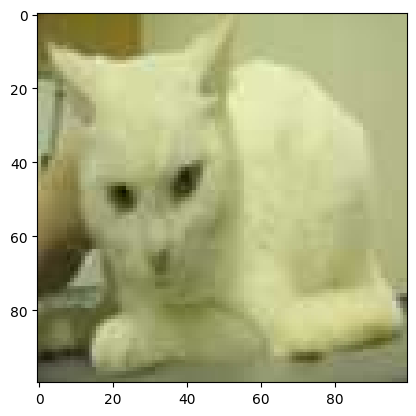

In [ ]:

img_plot = 13
cat0 = image.load_img(cat_dog + "/cat." + str(img_plot) + ".jpg")
plt.imshow(cat0)

## 17 Определение общего словаря для сохранения данных в формате json и списки для добавление значений в словарь

In [ ]:

animals = {}
# Список для изображений
animals_data = []
# Список для категорий
animals_labels = []

### 17.1 Запись в списки изображений и категорий в числовом формате

In [ ]:

count = 0
for img in os.listdir(cat_dog):
    count += 1
    if "cat" in img:
        # Для категории cat
        cat = image.load_img(cat_dog + "/" + img) # Загрузка изображения
        cat_arr = image.img_to_array(cat) # Преобразование в массив
        animals_data.append(cat_arr.tolist()) # Запись в список
        animals_labels.append(0) # Определение категории
    else:
        # Для категории dog
        dog = image.load_img(cat_dog + "/" + img)
        dog_arr = image.img_to_array(dog)
        animals_data.append(dog_arr.tolist())
        animals_labels.append(1)
    if count % 100 == 0:
        print(f"Загружено {count} изображений")

Загружено 100 изображений
Загружено 200 изображений
Загружено 300 изображений
Загружено 400 изображений
Загружено 500 изображений
Загружено 600 изображений
Загружено 700 изображений
Загружено 800 изображений
Загружено 900 изображений
Загружено 1000 изображений
Загружено 1100 изображений
Загружено 1200 изображений
Загружено 1300 изображений
Загружено 1400 изображений
Загружено 1500 изображений
Загружено 1600 изображений
Загружено 1700 изображений
Загружено 1800 изображений
Загружено 1900 изображений
Загружено 2000 изображений


### 17.2 Запись списков в словарь по соответствующим ключам

In [ ]:

animals["data"] = animals_data
animals["labels"] = animals_labels

## 18 Сохранение словаря в формате json

In [ ]:

file_name = "animals_j"
path_animal_to_json = cat_dog + "/" + file_name + ".json"
with open(path_animal_to_json, "w") as fj:
    json.dump(animals, fj)

## 19 Скачивания словаря в формате json

In [ ]:

cat_dog = path + "Cat_and_Dog"
path_animal_to_json = cat_dog + "/" + "animals_j" + ".json"
with open(path_animal_to_json, "r") as fp:
    animals_j = json.load(fp)

## 20 Перемешивание скачиного словаря

In [ ]:

animals = Shuffle_dict(animals_j)

## 21 Просмотр размера рабочего тензора

In [ ]:

animals['data'].shape

(2000, 100, 100, 3)

## 22 Опрееление массива с признаками и классами

In [ ]:

feature_ds = np.asarray(animals_j['data']) # Изображения
target_ds = np.asarray(animals_j['labels']) # Категории

## 23 Определени процента для тестовых выборок

In [ ]:

percent_test = 0.15

## 24 Определение размеров обучающих и тестовых выборок

In [ ]:

num_all_features = len(target_ds) # Общее количество изображений
start_test_data_idx = int(num_all_features * (1 - percent_test))
start_val_data_idx = int(num_all_features * (1 - (percent_test + percent_test)))
start_val_data_idx, start_test_data_idx

(1400, 1700)

In [ ]:
x_test = feature_ds[start_test_data_idx:] # От 1700 до 2000 (300)
y_test = target_ds[start_test_data_idx:] # От 1700 до 2000 (300)
x_val = feature_ds[start_val_data_idx:start_test_data_idx] # От 1400 до 1700 (300)
y_val = target_ds[start_val_data_idx:start_test_data_idx] # От 1400 до 1700 (300)
x_train = feature_ds[:start_val_data_idx] # От 0 до 1400
y_train = target_ds[:start_val_data_idx] # От 0 до 1400

In [ ]:
x_train.shape

(1400, 100, 100, 3)

## 25 Нормализация данных

In [ ]:

x_train = x_train / 255
x_val = x_val / 255
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [ ]:
input_shape = x_train.shape[1:]

## 26 Создание сверточной нейронной сети СНС M2

### 26.1 Создание слоев СНС М2

In [ ]:

model1 = Sequential()
model1.add(Conv2D(128, (3, 3), input_shape=input_shape, activation='relu'))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model1.add(Dropout(0.3))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))

### 26.2 Создание слоев СНС М3

In [ ]:

model2 = Sequential()
model2.add(Conv2D(128, (3, 3), input_shape=input_shape, activation='relu'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model2.add(Dropout(0.3))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

### 26.3 Определение оптимизаторов и функций потерь

In [ ]:

opt_adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
opt_rmsp = tf.keras.optimizers.legacy.RMSprop()
opt_sgd = tf.keras.optimizers.legacy.SGD()

loss_bce = tf.keras.losses.BinaryCrossentropy()
loss_cce = tf.keras.losses.CategoricalCrossentropy()

### 26.4 Запись необходимых параметром в единый рабочий словарь

In [ ]:

MyModel_1 = {}
MyModel_1['models'] = [model1]
MyModel_1['optimizers'] = [opt_adam]
MyModel_1['losses'] = [loss_bce]
epoch_list = 30
batch_list = 100

In [ ]:
MyModel_2 = {}
MyModel_2['models'] = [model2]
MyModel_2['optimizers'] = [opt_sgd]
MyModel_2['losses'] = [loss_bce]
epoch_list = 30
batch_list = 100

In [ ]:
y_val.shape, y_train.shape, x_train.shape, x_val.shape

((300,), (1400,), (1400, 100, 100, 3), (300, 100, 100, 3))

## 27 Запуск обучения модели М2 с оптимизатором Adam

In [ ]:

best_model = compile_models(MyModel_1, x_train, x_val, y_train, y_val, batch_list, epoch_list)

Start
Компиляция модели: Model 1  Optimizer 1  Loss 1  Batch=100  Epochs=30  Metrics=accuracy
Обучение модели: Model 1  Optimizer 1 Loss 1  Batch=100  Epochs=30  Metrics=accuracy
Epoch 1/30
14/14 [==============================] - 20s 322ms/step - loss: 7.3103 - accuracy: 0.4971 - val_loss: 0.6928 - val_accuracy: 0.5233
Epoch 2/30
14/14 [==============================] - 4s 267ms/step - loss: 0.6934 - accuracy: 0.4986 - val_loss: 0.6929 - val_accuracy: 0.5233
Epoch 3/30
14/14 [==============================] - 4s 275ms/step - loss: 0.6933 - accuracy: 0.4986 - val_loss: 0.6928 - val_accuracy: 0.5233
Epoch 4/30
14/14 [==============================] - 4s 265ms/step - loss: 0.6933 - accuracy: 0.4986 - val_loss: 0.6930 - val_accuracy: 0.5233
Epoch 5/30
14/14 [==============================] - 4s 281ms/step - loss: 0.6933 - accuracy: 0.4879 - val_loss: 0.6932 - val_accuracy: 0.4767
Epoch 6/30
14/14 [==============================] - 4s 266ms/step - loss: 0.6935 - accuracy: 0.4929 - val_loss

### 27.1 Проверка модели M2 на тестовой выборке

In [ ]:

predictions = model1.predict(x_test, verbose=0)

### 27.2 Определение имен классов

In [ ]:

class_names = ["cat", "dog"]

### 27.3 Просмотр изображения и вероятности предсказания модели М2

1.0 [0.5029369]


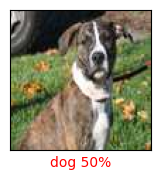

In [ ]:

i = 3
print(y_test[i], predictions[i])
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test, class_names)
plt.show()

### 27.4 Просмотр нескольких изображений и вероятность их предсказания моделью М2

['cat', 'dog']


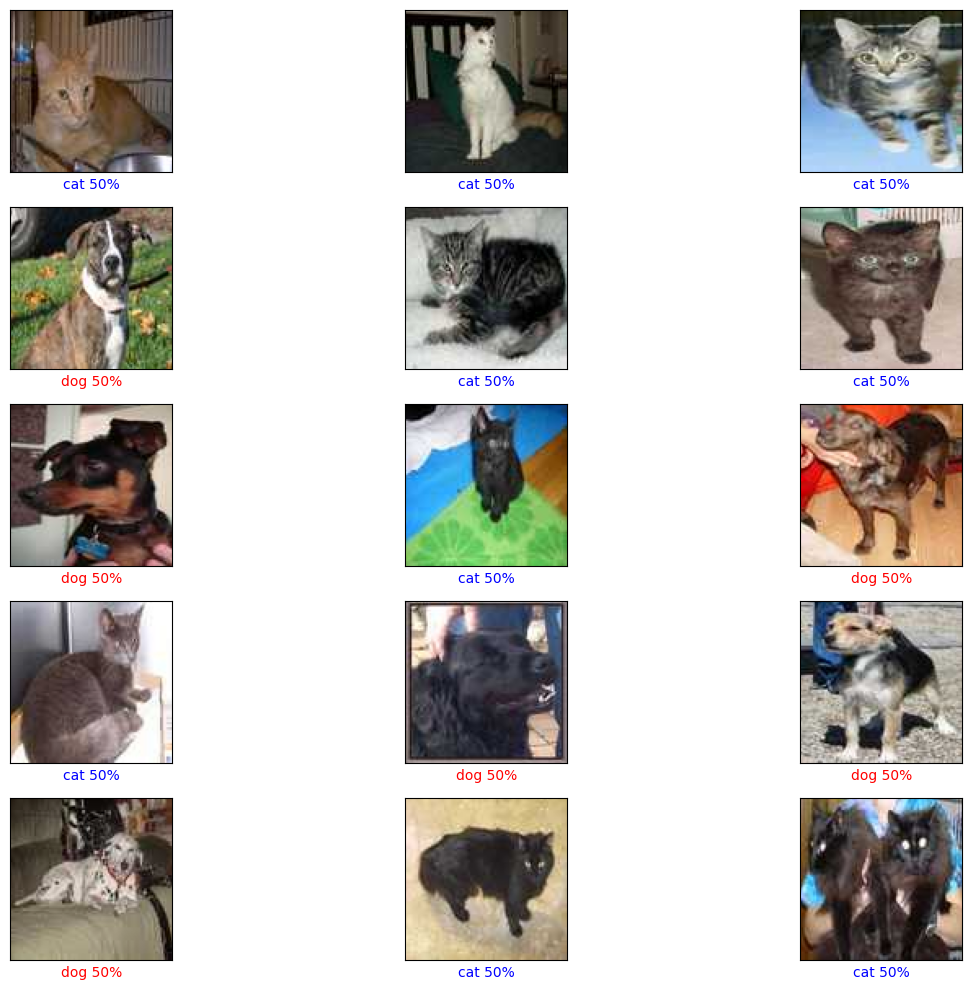

In [ ]:
print(class_names)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, x_test, class_names)
plt.tight_layout()
plt.show()

## 28 Запуск обучения модели М3 с оптимизатором SGD

In [ ]:

best_model_2 = compile_models(MyModel_2, x_train, x_val, y_train, y_val, batch_list, epoch_list)

Start
Компиляция модели: Model 1  Optimizer 1  Loss 1  Batch=100  Epochs=30  Metrics=accuracy
Обучение модели: Model 1  Optimizer 1 Loss 1  Batch=100  Epochs=30  Metrics=accuracy
Epoch 1/30
14/14 [==============================] - 6s 301ms/step - loss: 0.6934 - accuracy: 0.4857 - val_loss: 0.6923 - val_accuracy: 0.5467
Epoch 2/30
14/14 [==============================] - 4s 286ms/step - loss: 0.6931 - accuracy: 0.5114 - val_loss: 0.6922 - val_accuracy: 0.5533
Epoch 3/30
14/14 [==============================] - 4s 280ms/step - loss: 0.6930 - accuracy: 0.4993 - val_loss: 0.6921 - val_accuracy: 0.5633
Epoch 4/30
14/14 [==============================] - 4s 288ms/step - loss: 0.6935 - accuracy: 0.5014 - val_loss: 0.6921 - val_accuracy: 0.5667
Epoch 5/30
14/14 [==============================] - 4s 277ms/step - loss: 0.6926 - accuracy: 0.5186 - val_loss: 0.6921 - val_accuracy: 0.5433
Epoch 6/30
14/14 [==============================] - 4s 279ms/step - loss: 0.6923 - accuracy: 0.5114 - val_loss:

### 28.1 Проверка модели M3 на тестовой выборке

In [ ]:

predictions2 = model2.predict(x_test, verbose=0)

### 28.2 Просмотр изображения и вероятности предсказания модели М3

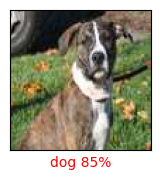

In [ ]:

i = 3
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plot_image(i, predictions2[i], y_test, x_test, class_names)
plt.show()

### 28.3 Просмотр нескольких изображений и вероятность их предсказания моделью М2

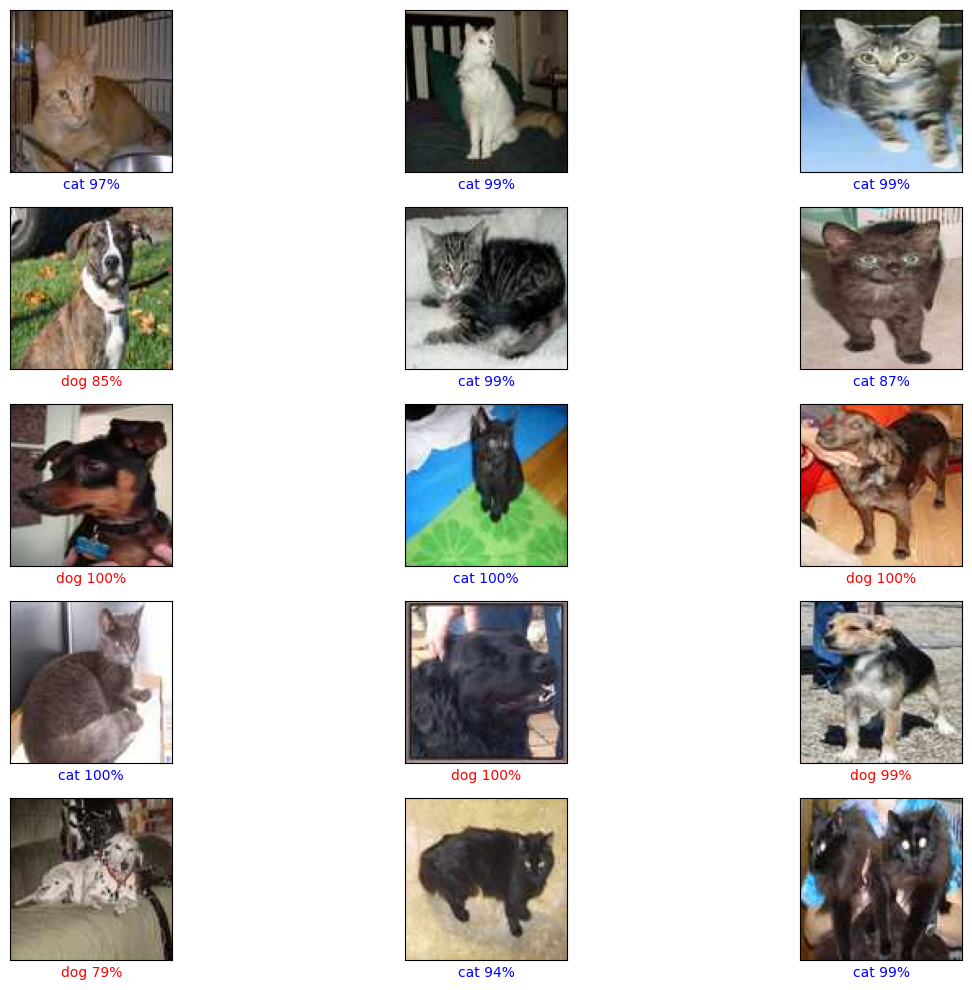

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols*2, 2*i+1)
    plot_image(i, predictions2[i], y_test, x_test, class_names)
plt.tight_layout()
plt.show()

## 29 Сохранение моделей М1 и М2

In [ ]:
model1.save('drive/MyDrive/My_model_1/')
model2.save('drive/MyDrive/My_model_2/')

## 30 Просмотр структуры модели М1

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 128)       3584      
                                                                 
 conv2d_19 (Conv2D)          (None, 98, 98, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 49, 49, 128)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 49, 49, 128)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 49, 49, 64)        73792     
                                                                 
 conv2d_21 (Conv2D)          (None, 47, 47, 64)        36928     
                                                      

## 31 Просмотр структуры модели М3

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 98, 98, 128)       3584      
                                                                 
 conv2d_25 (Conv2D)          (None, 98, 98, 128)       147584    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 49, 49, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 49, 49, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 49, 49, 64)        73792     
                                                                 
 conv2d_27 (Conv2D)          (None, 47, 47, 64)        36928     
                                                      

## Вывод

Порезультатам тестирования трех моделей М1 с использование генератора ImageDataGenerator оптимизатором Adam, модели М2 с оптимизатором Adam и М3 с оптимизатором SGD было выявлено, что точность предсказания модели М3 составила в среднем 80 % При обучение модели с оптимизатором SGD на 30 эпохах модель закончила обучения 19-й эпохе, на что было затрачено 85 сек.
Модель М2 справилась с задачей значительно хуже показав точность предсказания в средне 50 %
Средняя точность модели М1 составила 50.43 %
Также необходимо учесть, что модель М1 тестировалась на объеме в два раза меньшем чем модели М2 и М3 и при этом её скорость обучения значительно выше, чем у М2 и М3. Это обусловлено тем, что для обучения моделей М2 и М3 использовалась предварительная подготовка данных путем сжатия изображений.
Главный вывод по трем моделям.
Наилучший оптимизаор для классификации изображений SGD. Потому что, это уже не первый опыт в тестировании СНС для классификации изображений. И каждый раз модели с оптимизатором SGD показывают наилучшие результаты.
Да. Определенно подготовка данных для моделей М2 и М3 занимает больше времени. Поэтому следует использовать модель М1, которую необходимо обучить по новой с оптимизатором SGD и набольшем объеме данных. Процесс обучения будет не из быстрых, но по конечному итогу отпадает необходимость в предварительной подготовке данных